In [25]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [26]:
RAV = "/home/volodymyr/DataspellProjects/pythonProject/audio_speech_actors_01-24/"

In [27]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_calm        96
female_fear        96
male_fear          96
female_disgust     96
male_calm          96
male_angry         96
female_angry       96
female_sad         96
female_happy       96
male_happy         96
female_surprise    96
male_sad           96
male_surprise      96
male_disgust       96
female_neutral     48
male_neutral       48
Name: labels, dtype: int64

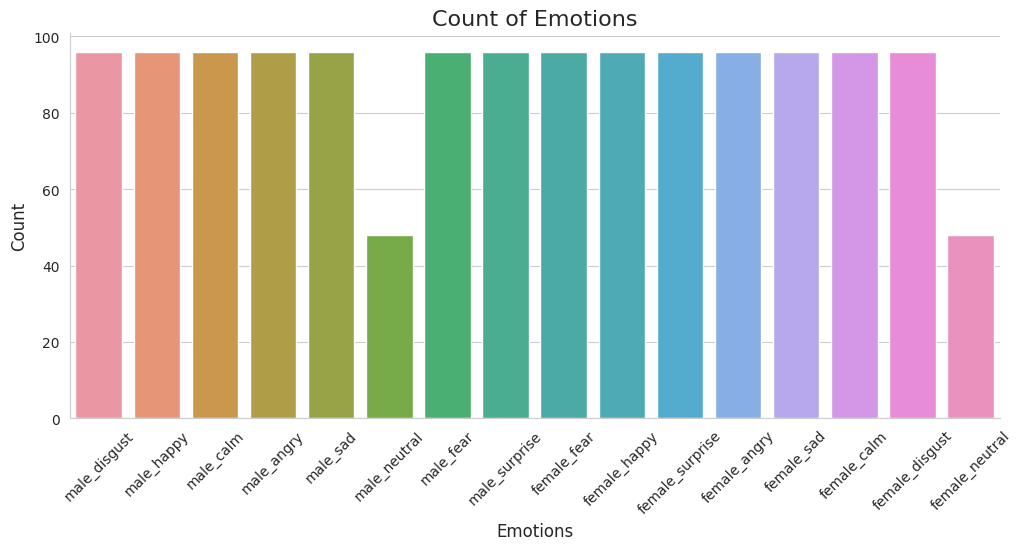

In [28]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAV_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [29]:
# MALE NEUTRAL
fname1=RAV+'Actor_01/03-01-01-01-01-01-01.wav'
data, sr = librosa.load(fname1)
ipd.Audio(fname1)


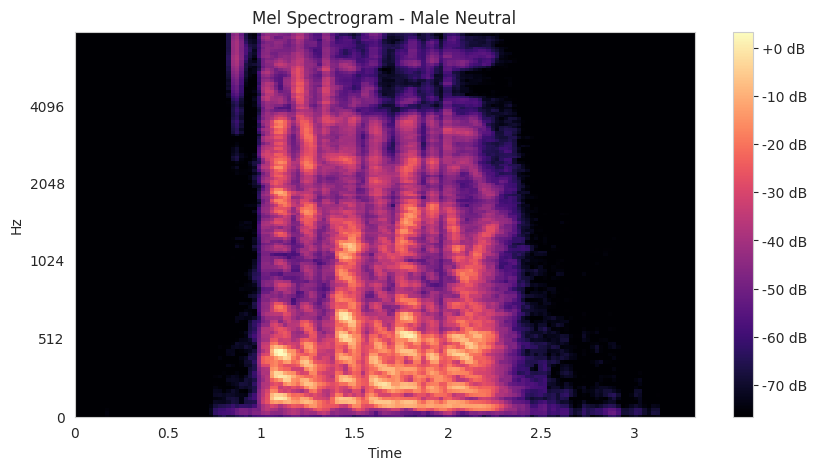

In [30]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.colorbar(format='%+2.0f dB');

In [31]:
# FEMALE NEUTRAL
fname2=RAV+'Actor_14/03-01-01-01-01-01-14.wav'
data, sr = librosa.load(fname2)
ipd.Audio(fname2)

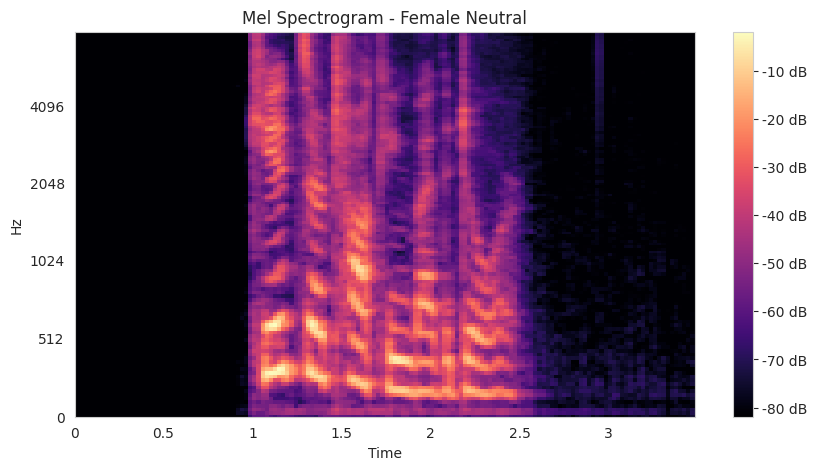

In [32]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Neutral')
plt.colorbar(format='%+2.0f dB');

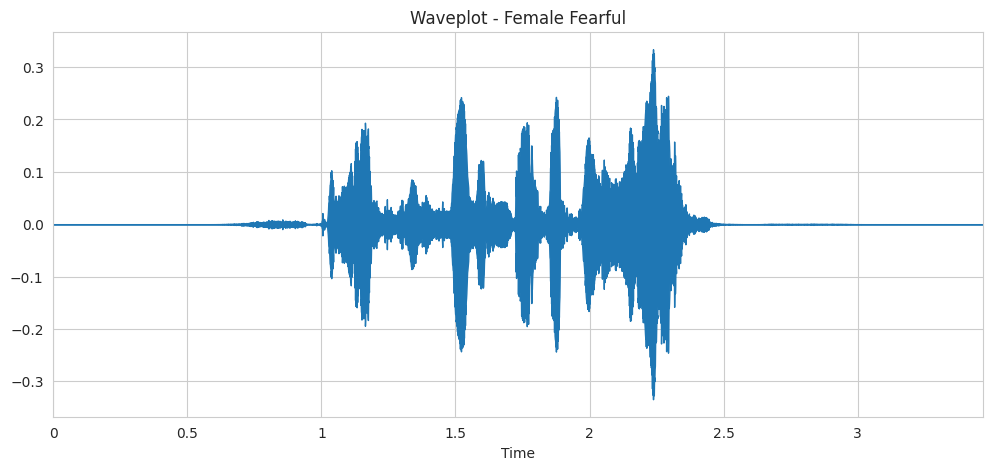

In [33]:
# Pick a fearful track
fname3 = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'
data, sr = librosa.load(fname3)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Fearful')
# Lets play the audio
ipd.Audio(fname3)

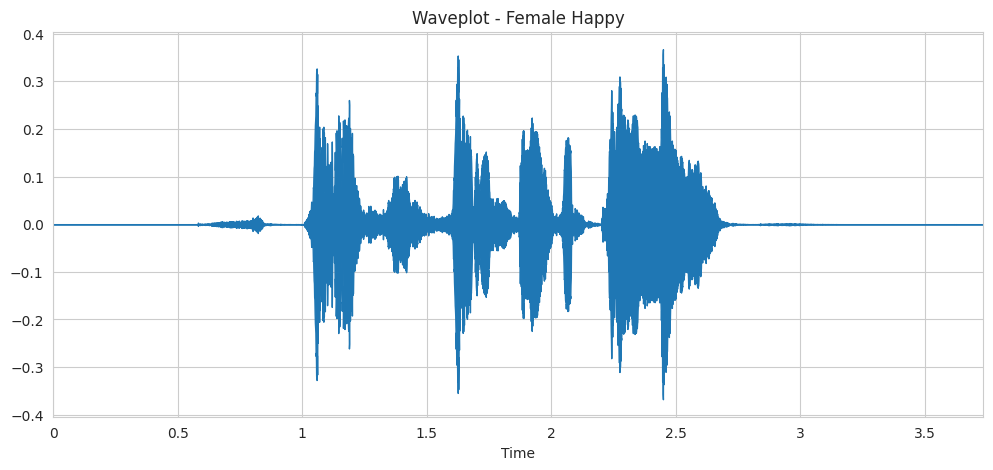

In [34]:
# Pick a happy track
fname4 = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'
data, sr = librosa.load(fname4)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Happy')

# Lets play the audio
ipd.Audio(fname4)

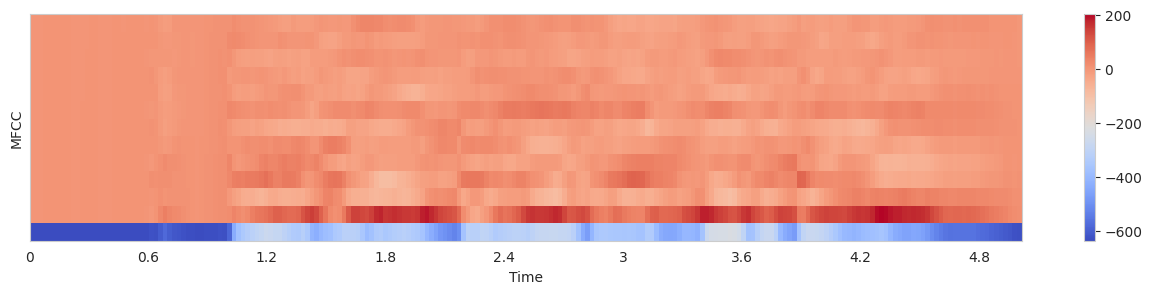

In [35]:
# Gender - Female; Emotion - Angry
path = RAV +  "Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

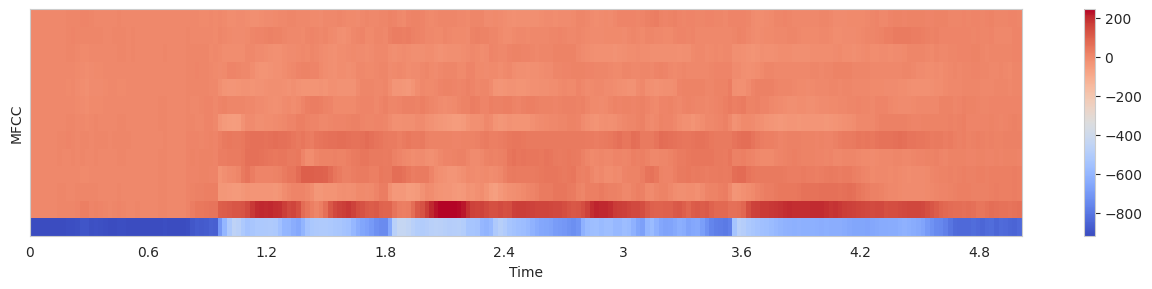

In [36]:
# Gender - Male; Emotion - Angry
path = RAV + "Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


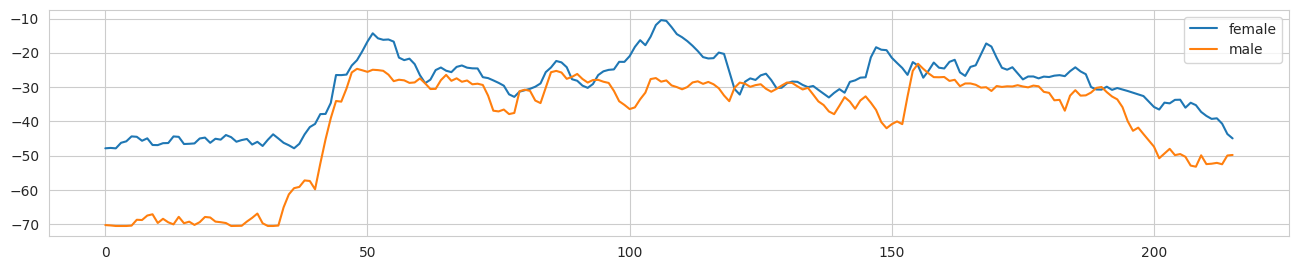

In [37]:
# Gender - Female; Emotion - angry
path = RAV + "Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Male; Emotion - angry
path = RAV + "Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [38]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [39]:
# Trying different functions above
path = np.array(RAV_df['path'])[303]
data, sample_rate = librosa.load(path)

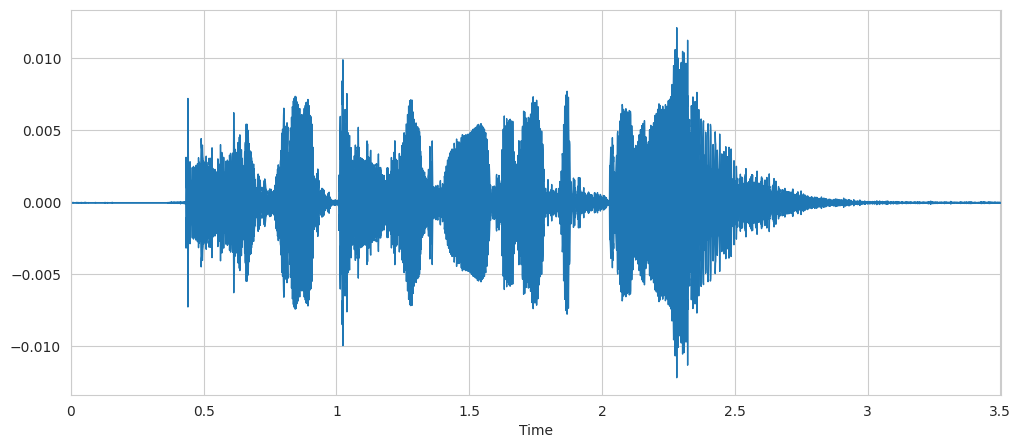

In [40]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

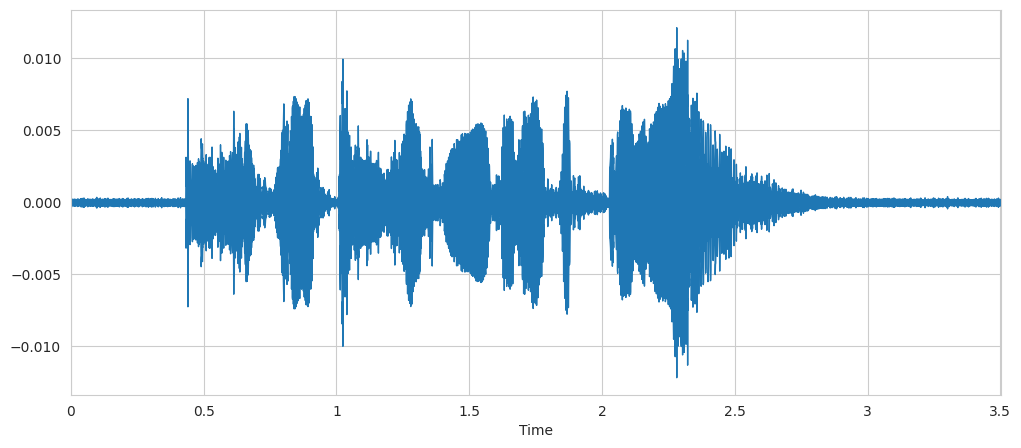

In [41]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

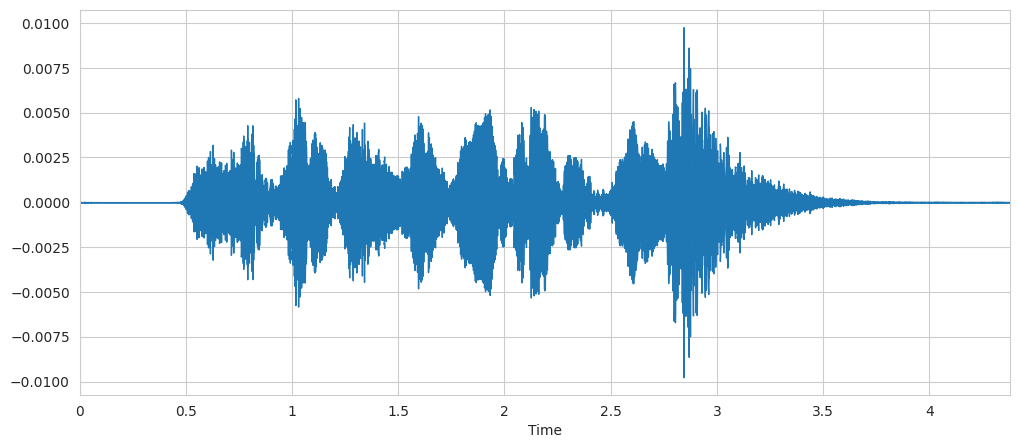

In [42]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

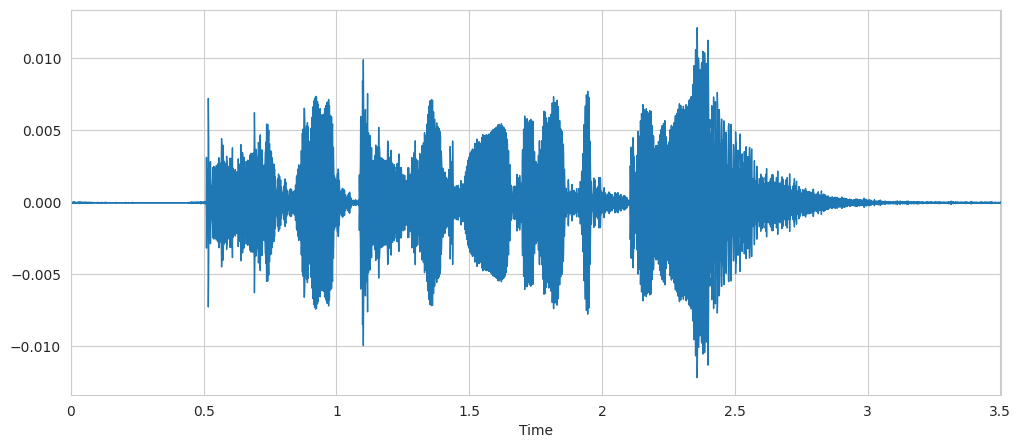

In [43]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

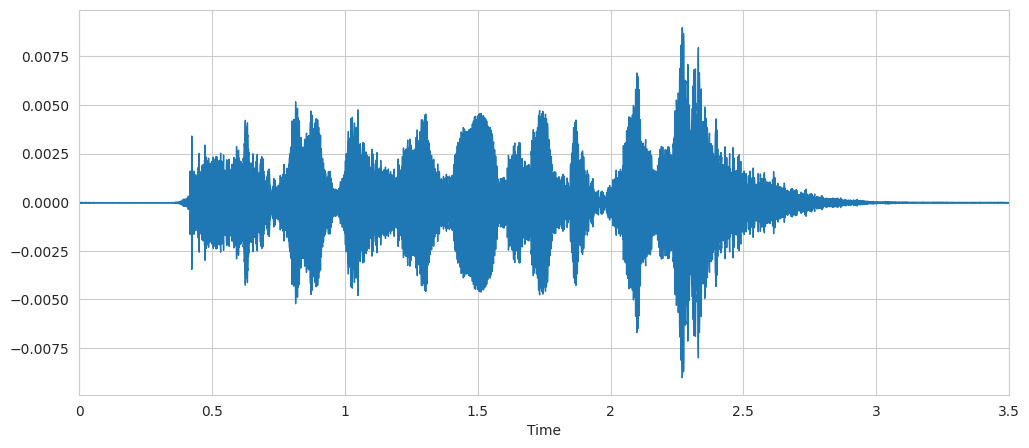

In [44]:
# AUDIO WITH PITCH
x = pitch(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [45]:

def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [46]:
RAV_df.head()

labels   source                                               path
0  male_disgust  RAVDESS  /home/volodymyr/DataspellProjects/pythonProjec...
1    male_happy  RAVDESS  /home/volodymyr/DataspellProjects/pythonProjec...
2  male_disgust  RAVDESS  /home/volodymyr/DataspellProjects/pythonProjec...
3     male_calm  RAVDESS  /home/volodymyr/DataspellProjects/pythonProjec...
4    male_angry  RAVDESS  /home/volodymyr/DataspellProjects/pythonProjec...

In [47]:
X, Y = [], []
for path, emotion in zip(RAV_df['path'], RAV_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [48]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0          1         2          3          4         5          6  \
0 -410.110535  58.347313 -4.590334   7.712727  -9.975654 -2.607515 -22.592396   
1 -348.476518  41.804015  4.688595   4.400815  -4.514903 -2.706651 -17.840945   
2 -467.818604  54.454491 -4.978843   5.326154 -12.048777 -3.143886 -26.794846   
3 -576.267395  89.021942 -8.751031  18.866085   3.268405 -2.776171 -10.327026   
4 -426.474151  43.545049  7.266498  11.204431   2.848064 -4.502358  -5.503841   

           7          8         9  ...        11         12        13  \
0 -21.421492 -14.513188 -8.488676  ... -6.182153 -14.559880 -7.466559   
1 -18.293047 -11.195363 -8.715919  ... -4.451518  -9.147892 -6.664846   
2 -21.761971 -14.400508 -8.810847  ... -6.971991 -16.041811 -6.149279   
3  -7.969184 -18.382338 -2.059610  ... -8.216556  -0.477188 -5.304438   
4  -8.304971 -11.099382 -5.765310  ... -5.505002  -2.577024 -3.922923   

         14        15         16        17        18        19        labels  
0 -9.174990  1.986812 -14.750596 -2.197861 -7.241165 -4.102223  male_disgust  
1 -4.058845 -0.248342  -8.862097 -2.917056 -3.484890 -4.623573  male_disgust  
2 -5.723185 -0.482331 -16.212273 -0.420305 -8.786963 -5.526899  male_disgust  
3 -5.272919  4.181663 -12.839043 -2.812845 -4.986218 -2.452225    male_happy  
4 -3.614325 -0.979339  -6.484320 -5.617657 -2.070493 -4.593374    male_happy  

[5 rows x 21 columns]

In [49]:
# can use this directly from saved feature .csv file
Features = pd.read_csv('/home/volodymyr/DataspellProjects/pythonProject/features.csv')
Features.head()

0          1         2          3          4         5          6  \
0 -410.110535  58.347313 -4.590334   7.712727  -9.975654 -2.607515 -22.592396   
1 -348.476518  41.804015  4.688595   4.400815  -4.514903 -2.706651 -17.840945   
2 -467.818604  54.454491 -4.978843   5.326154 -12.048777 -3.143886 -26.794846   
3 -576.267395  89.021942 -8.751031  18.866085   3.268405 -2.776171 -10.327026   
4 -426.474151  43.545049  7.266498  11.204431   2.848064 -4.502358  -5.503841   

           7          8         9  ...        11         12        13  \
0 -21.421492 -14.513188 -8.488676  ... -6.182153 -14.559880 -7.466559   
1 -18.293047 -11.195363 -8.715919  ... -4.451518  -9.147892 -6.664846   
2 -21.761971 -14.400508 -8.810847  ... -6.971991 -16.041811 -6.149279   
3  -7.969184 -18.382338 -2.059610  ... -8.216556  -0.477188 -5.304438   
4  -8.304971 -11.099382 -5.765310  ... -5.505002  -2.577024 -3.922923   

         14        15         16        17        18        19        labels  
0 -9.174990  1.986812 -14.750596 -2.197861 -7.241165 -4.102223  male_disgust  
1 -4.058845 -0.248342  -8.862097 -2.917056 -3.484890 -4.623573  male_disgust  
2 -5.723185 -0.482331 -16.212273 -0.420305 -8.786963 -5.526899  male_disgust  
3 -5.272919  4.181663 -12.839043 -2.812845 -4.986218 -2.452225    male_happy  
4 -3.614325 -0.979339  -6.484320 -5.617657 -2.070493 -4.593374    male_happy  

[5 rows x 21 columns]

In [50]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [51]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [52]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

In [53]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

In [54]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=3)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [55]:
y_pred=clf1.predict(x_test)

In [56]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.843
Test set score: 0.649


In [57]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=400)

In [58]:
y_pred=clf2.predict(x_test)
y_pred.shape

(1080, 16)

In [59]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.913
Test set score: 0.619


In [60]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 16), (1080, 20, 1), (1080, 16))

In [61]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
x_traincnn.shape

2023-05-25 12:59:46.258582: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-25 12:59:46.290045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-25 12:59:46.325568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 12:59:46.325679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.485GHz coreCount: 20 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-25 12:59:46.325746: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object fi

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 2048)          12288     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 2048)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 2048)          8192      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 1024)          10486784  
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 1024)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 1024)           4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 512)            2

(3240, 20, 1)

In [62]:
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=50, validation_data=(x_testcnn, y_test))

Epoch 1/50


2023-05-25 12:59:46.693890: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-25 12:59:46.694779: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz


 7/51 [===>..........................] - ETA: 44s - loss: 2.7703 - accuracy: 0.0733

KeyboardInterrupt: 

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
#Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [72]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [73]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/home/volodymyr/Downloads/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

Loaded model from disk


In [74]:
import soundfile as sf
p = '/home/volodymyr/DataspellProjects/pythonProject/Recording2.wav'
rav = "/home/volodymyr/DataspellProjects/pythonProject/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav"
data, sampling_rate = librosa.load(p)


In [75]:
% pylab inline
import os
import pandas as pd
import librosa
import glob


UsageError: Line magic function `%` not found.


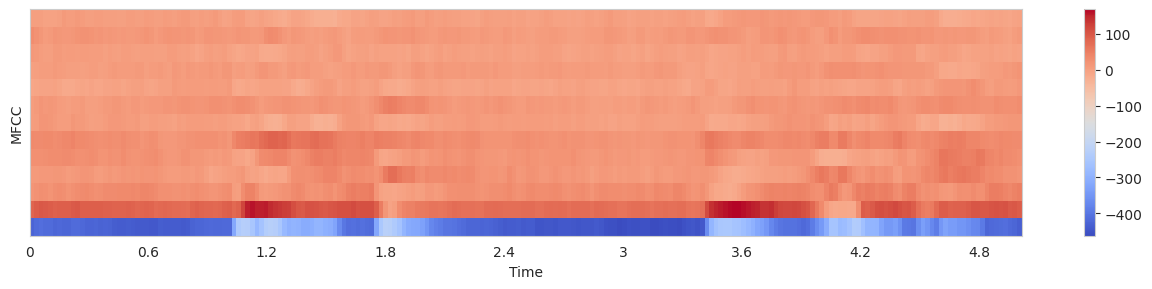

In [85]:
path = p
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

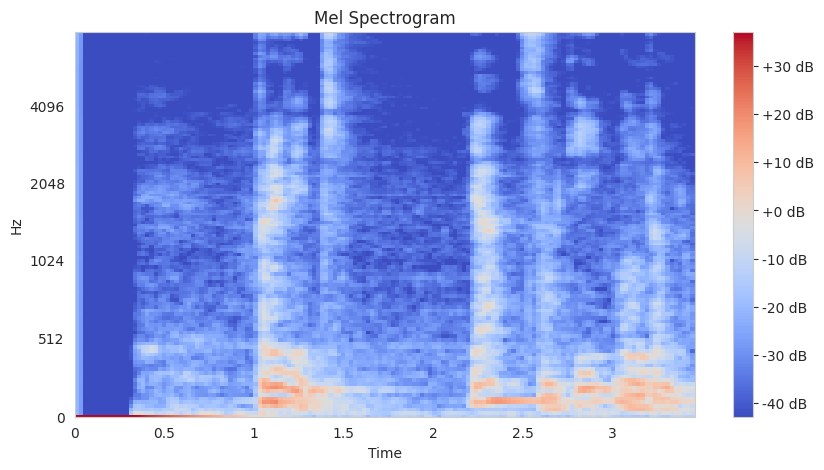

In [86]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB');

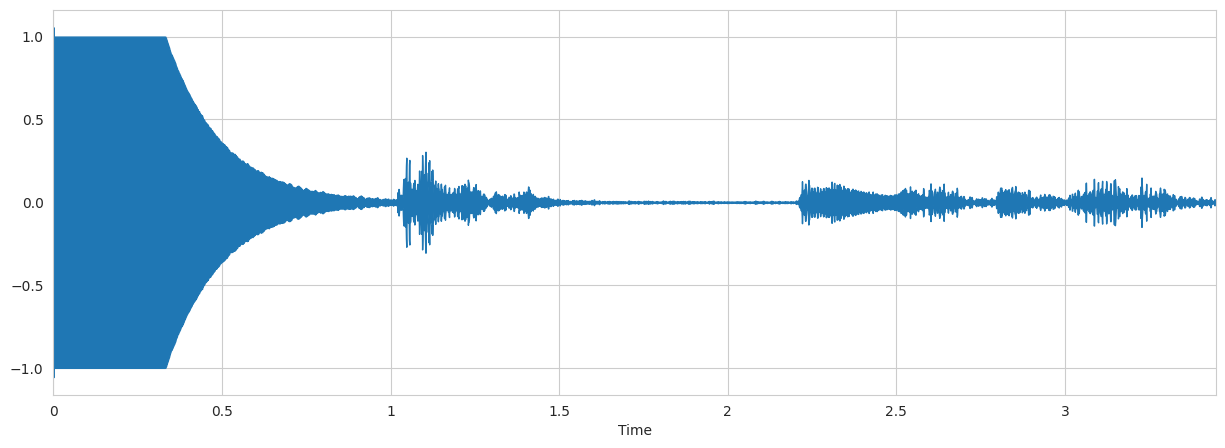

In [76]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [77]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load(p, res_type='kaiser_fast',duration=3 ,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [78]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

0          1          2          3          4          5    \
           0          0          0          0          0          0   
0 -16.610035 -14.968999 -13.014886 -14.573409 -14.644497 -14.429186   

         6          7          8          9    ...        244       245  \
           0          0          0          0  ...          0         0   
0 -14.791499 -15.987184 -16.952267 -14.108673  ... -10.000399 -8.046886   

        246        247        248        249       250        251        252  \
          0          0          0          0         0          0          0   
0 -8.765241 -10.127275 -11.737803 -11.762136 -9.728058 -11.050482 -11.219555   

         253  
           0  
0 -11.612823  

[1 rows x 254 columns]

In [79]:
twodim= np.expand_dims(livedf2, axis=2)

In [80]:
livepreds = loaded_model.predict(twodim,
                                 batch_size=32,
                                 verbose=1)

1/1 [==============================] - 0s 396ms/step


In [81]:
livepreds

array([[9.2204152e-07, 9.6360892e-01, 3.6388144e-02, 6.9945916e-10,
        2.8495033e-09, 1.5811968e-09, 3.9447130e-07, 6.7924303e-12,
        1.4748157e-06, 3.3580687e-08, 7.5787185e-08, 1.4806080e-13,
        1.6061583e-09, 6.1020335e-11, 8.3102151e-17, 3.3286432e-13]],
      dtype=float32)

In [82]:
livepreds.shape

(1, 16)

In [83]:

livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions

array([['female_calm']], dtype=object)

190
216


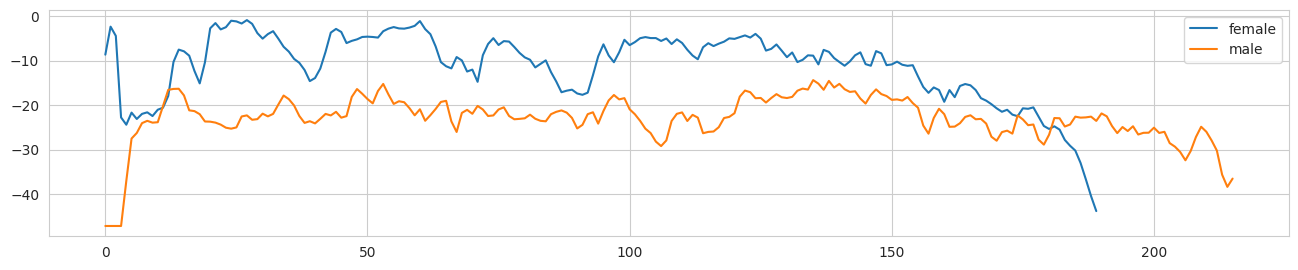

In [87]:
# Gender - Male; Emotion - calm
path = "/home/volodymyr/DataspellProjects/pythonProject/audio_2023-05-23_21-15-20.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Female; Emotion - calm
path = "/home/volodymyr/DataspellProjects/pythonProject/audio_2023-05-23_21-17-40.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

216
216


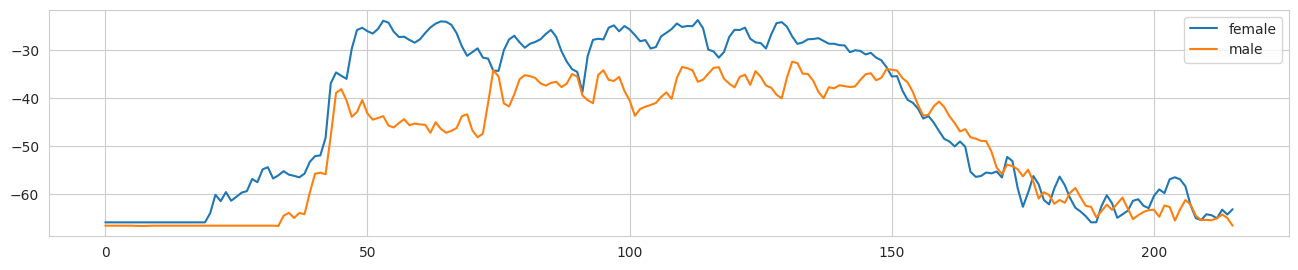

In [88]:
# Gender - Male; Emotion - calm
path = "/home/volodymyr/DataspellProjects/pythonProject/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Female; Emotion - calm
path = "/home/volodymyr/DataspellProjects/pythonProject/audio_speech_actors_01-24/Actor_04/03-01-01-01-01-01-04.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()